Ellenséges mérgezéses támadás ML modellek ellen

Néhány egyszerűbb modellen generált mérgező pontokból állítok elő egy olyan adathalmazt, melyekkel a cél a tanuló algoritmusok eltérítése.


In [109]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

# A SECML csomagot használom fel a kísérlethez

try:
  import secml
except ImportError:
  %pip install git+https://gitlab.com/secml/secml
    
from random import *

import numpy as np
import time
import sys

#print 'Number of arguments:', len(sys.argv), 'arguments.'
#print 'Argument List:', str(sys.argv)

# exp.py "thread" "seed"
# first is scriptname!
# random seed , thread, 

if (len(sys.argv) == 3):
    sys.argv[0] = 'Notebook'
    sys.argv[1] = '01'
    sys.argv[2] = '123'

Adatgeneráláshoz különböző eloszlások függvényei

In [100]:
# Pareto eloszlás generálása
from secml.array import CArray
from random import *

def rpareto_inv(n, theta, a):
    import numpy as np
    u = np.random.uniform(low=0.0, high=1.0, size=n)
    return (theta / pow(u, (1 / a)))

def rpareto_cond_inv(x2, theta1, theta2, a):
    import numpy as np
    u = np.random.uniform(low=0.0, high=1.0, size=len(x2))
    return (theta1 + theta1 / theta2 * x2 * (1 /  pow(u , (1 / (a + 1))) - 1))


def rpareto_dataset(n, theta1, theta2, a, label):
    import secml
    from secml.data import CDataset
    x2 = rpareto_inv(n, theta2, a)
    x1 = rpareto_cond_inv(x2, theta1, theta2, a)

    ds = CDataset([[x1[0], x2[0]]],[label])
    
    for x in range(1,n-1):
        ds = ds.append(CDataset([[x1[x], x2[x]]],[label]))
    
    return ds

In [101]:
# Random egyszínű pontok egyenletes eloszlása

def runiform2d(n, lowX, highX, lowY, highY, label):
    import numpy as np
    uX = np.random.uniform(low=lowX, high=highX, size=n)
    uY = np.random.uniform(low=lowY, high=highY, size=n)
    
    import secml
    from secml.data import CDataset

    ds = CDataset([[uX[0], uY[0]]],[label])
    
    for x in range(1,n-1):
        ds = ds.append(CDataset([[uX[x], uY[x]]],[label]))
    
    return ds

In [102]:
# Gauss eloszlás

def rgauss_dataset(n, mux1, mux2, sigma, label):
    # import the required libraries
    import random
    import matplotlib.pyplot as plt

    # store the random numbers in a list
    nums = []
    nums2 = []

    for i in range(n):
        temp = random.gauss(mux1, sigma)
        nums.append(temp)
    
    for i in range(n):
        temp = random.gauss(mux2, sigma)
        nums2.append(temp)
    
    import secml
    from secml.data import CDataset

    ds = CDataset([[nums[0], nums2[0]]],[label])
    
    for x in range(1,n-1):
        ds = ds.append(CDataset([[nums[x], nums2[x]]],[label]))
    
    return ds

In [103]:
# SECML kibővítése a XGBoost-tal, mely nem része a csomagnak
from secml.ml.classifiers import CClassifierSkLearn

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier


#[docs]
class CClassifierXGBoost(CClassifierSkLearn):
    """XGBoost classifier.

    Parameters
    ----------
        n_estimators (int) – Number of boosting rounds.

        max_depth (Optional[int]) – Maximum tree depth for base learners.

        learning_rate (Optional[float]) – Boosting learning rate (xgb’s “eta”)

        verbosity (Optional[int]) – The degree of verbosity. Valid values are 0 (silent) - 3 (debug).

        objective (typing.Union[str, typing.Callable[[numpy.ndarray, numpy.ndarray], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).

        booster (Optional[str]) – Specify which booster to use: gbtree, gblinear or dart.

        tree_method (Optional[str]) – Specify which tree method to use. Default to auto. If this parameter is set to default, XGBoost will choose the most conservative option available. It’s recommended to study this option from the parameters document: https://xgboost.readthedocs.io/en/latest/treemethod.html.

        n_jobs (Optional[int]) – Number of parallel threads used to run xgboost. When used with other Scikit-Learn algorithms like grid search, you may choose which algorithm to parallelize and balance the threads. Creating thread contention will significantly slow down both algorithms.

        gamma (Optional[float]) – Minimum loss reduction required to make a further partition on a leaf node of the tree.

        min_child_weight (Optional[float]) – Minimum sum of instance weight(hessian) needed in a child.

        max_delta_step (Optional[float]) – Maximum delta step we allow each tree’s weight estimation to be.

        subsample (Optional[float]) – Subsample ratio of the training instance.

        colsample_bytree (Optional[float]) – Subsample ratio of columns when constructing each tree.

        colsample_bylevel (Optional[float]) – Subsample ratio of columns for each level.

        colsample_bynode (Optional[float]) – Subsample ratio of columns for each split.

        reg_alpha (Optional[float]) – L1 regularization term on weights (xgb’s alpha).

        reg_lambda (Optional[float]) – L2 regularization term on weights (xgb’s lambda).

        scale_pos_weight (Optional[float]) – Balancing of positive and negative weights.

        base_score (Optional[float]) – The initial prediction score of all instances, global bias.

        random_state (Optional[Union[numpy.random.RandomState, int]]) – Random number seed.

Note

    Attributes
    ----------
    class_type : 'xgboost'

    """
    __class_type = 'xgboost'

    def __init__(self, n_estimators=10,
                 max_depth=None, learning_rate=0.001, use_label_encoder=False, random_state=None,
            preprocess=None, eval_metric='logloss'):

        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            #verbosity=verbosity,
            #objective=objective,
            #booster=booster,
            #tree_method=tree_method,
            #n_jobs=n_jobs,
            #gamma=gamma,
            #min_child_weight=min_child_weight,
            #max_delta_step=max_delta_step,
            #subsample=subsample,
            #colsample_bytree=colsample_bytree,
            #colsample_bylevel=colsample_bylevel,
            #colsample_bynode=colsample_bynode,
            #reg_alpha=reg_alpha,
            #reg_lambda=reg_lambda,
            #scale_pos_weight=scale_pos_weight,
            #base_score=base_score,
            random_state=random_state,
            preprocess=preprocess,
            use_label_encoder=use_label_encoder,
            eval_metric=eval_metric
        )

        CClassifierSkLearn.__init__(self, sklearn_model=xgb,
                                    preprocess=preprocess)


In [110]:
# Random dataset generátor függvény
# Mindne indításkor változó adatokat generál különböző eloszlásokból

def random_dataset(ndataset = 800, nd = 3000):
    import random

    weightselector = random.uniform(0,1)

    w0 = 0
    w1 = 0

    # 50% to test the values with the same weights
    if(weightselector < 0.5):
        w0 = 0.5
        w1 = 0.5
    # 50% to test the values with random weights
    else:
        w0 = random.uniform(0.10,0.40)
        w1 = 1-w0
    print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + str(w0), str(w1))

    # Random Distribution Selector
    # The weights are equal for the distribution selection

    # Label 0:
    dist_sel = random.randrange(0,5)

    if(dist_sel == 0):
        # Gauss
        dataset = rgauss_dataset(n = nd, mux1 = random.randrange(2,8), mux2= random.randrange(2,8), sigma = random.uniform(0,1)*5, label = 0)
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Gauss')
    elif(dist_sel == 1):
    # Double Gauss long distance
        mux1 = random.randrange(2,8)
        mux2 = random.randrange(2,8)
        dataset = rgauss_dataset(n = int(nd/2), mux1 = mux1, mux2= mux2, sigma = random.uniform(0,1)*5, label = 0)
    
        if(mux1 < 5):
            mux1 = random.randrange(mux1,8)
        else:
            mux1 = random.randrange(2,mux1)
        
        if(mux2 < 5):
            mux2 = random.randrange(mux2,8)
        else:
            mux2 = random.randrange(2,mux2)
    
        dataset = dataset.append(rgauss_dataset(n = int(nd/2), mux1 = mux1, mux2= mux2, sigma = random.uniform(0,1)*5, label = 0))
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Double Gauss Long')
    elif(dist_sel == 2):
    # Double Gauss short distance
        gw = random.uniform(0,1)

        mux1 = random.randrange(2,8)
        mux2 = random.randrange(2,8)
        sigma = random.uniform(0,1)*5
    
        dataset = rgauss_dataset(n = int(nd * gw), mux1 = mux1, mux2= mux2, sigma = sigma, label = 0)
    
        mux1 = random.uniform(mux1-2*sigma,mux1+2*sigma)
        mux2 = random.uniform(mux1-2*sigma,mux1+2*sigma)
    
        dataset = dataset.append(rgauss_dataset(n = int(nd * (1- gw)), mux1 = mux1, mux2= mux2, sigma = random.uniform(0.3,1)*5, label = 0))
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Double Gauss Short')
    elif(dist_sel == 3):
    # Unifrom
        dataset = runiform2d(n=nd, lowX=0.0, highX=10.0, lowY=0.0, highY=10.0, label=0)
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Uniform')
    elif(dist_sel == 4):
    # Pareto
        dataset = rpareto_dataset(n = nd, theta1 = 1, theta2 = 1, a = random.uniform(0,1)*1.75+2.25, label =0)
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Pareto')
    else:
        print("Error, the selected distribution is not implemented.")
    
    
    # Label 1:
    dist_sel = random.randrange(0,5)
    print(dist_sel)
    if(dist_sel == 0):
    # Gauss
        dataset2 = rgauss_dataset(n = nd, mux1 = random.randrange(2,8), mux2= random.randrange(2,8), sigma = random.uniform(0.3,1)*5, label = 1)
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Gauss')
    elif(dist_sel == 1):
    # Double Gauss long distance
        mux1 = random.randrange(2,8)
        mux2 = random.randrange(2,8)
        dataset2 = rgauss_dataset(n = int(nd/2), mux1 = mux1, mux2= mux2, sigma = random.uniform(0,1)*5, label = 1)
    
        if(mux1 < 5):
            mux1 = random.randrange(mux1,8)
        else:
            mux1 = random.randrange(2,mux1)
        
        if(mux2 < 5):
            mux2 = random.randrange(mux2,8)
        else:
            mux2 = random.randrange(2,mux2)
    
        dataset2 = dataset2.append(rgauss_dataset(n = int(nd/2), mux1 = mux1, mux2= mux2, sigma = random.uniform(0.3,1)*5, label = 1))
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Double Gauss Long')

    elif(dist_sel == 2):
    # Double Gauss short distance
        gw = random.uniform(0,1)

        mux1 = random.randrange(2,8)
        mux2 = random.randrange(2,8)
        sigma = random.uniform(0,1)*5
    
        dataset2 = rgauss_dataset(n = int(nd * gw), mux1 = mux1, mux2= mux2, sigma = sigma, label = 1)
    
        mux1 = random.uniform(mux1-2*sigma,mux1+2*sigma)
        mux2 = random.uniform(mux1-2*sigma,mux1+2*sigma)
    
        dataset2 = dataset2.append(rgauss_dataset(n = int(nd * (1- gw)), mux1 = mux1, mux2= mux2, sigma = random.uniform(0.3,1)*5, label = 1))
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Double Gauss Short')
    elif(dist_sel == 3):
    # Unifrom
        dataset2 = runiform2d(n=nd, lowX=0.0, highX=10.0, lowY=0.0, highY=10.0, label=1)
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Uniform')
    elif(dist_sel == 4):
    # Pareto
        dataset2 = rpareto_dataset(n = nd, theta1 = 1, theta2 = 1, a = random.uniform(0,1)*1.75+2.25, label = 1)
        print('\nEXPDES\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' + 'Pareto')
    else:
        print("Error, the selected distribution is not implemented.")
    
    # Weighted sample from the distributions
    # w0 and w1 the weigths, nd the sample n

    rndarray = []
    rndselector = []

    for x in range(ndataset):
        rndarray.append(randint(0, nd-1))
        rndselector.append(random.uniform(0,1))
    
    for q in range(0,ndataset-1):
        if (q == 0 and rndselector[0] < w0):
            randsample = dataset[[rndarray[0]],[0,1]]
        elif (q == 0 and rndselector[0] >= w0):
            randsample = dataset2[[rndarray[0]],[0,1]]
        elif (rndselector[q] < w0):
            randsample = randsample.append(dataset[[q],[0,1]])
        else:
            randsample = randsample.append(dataset2[[q],[0,1]])

    return randsample


EXPDES	01	123	Mon Nov  1 17:59:30 2021	0.1676663470642878 0.8323336529357122

EXPDES	01	123	Mon Nov  1 17:59:30 2021	Double Gauss Short
1

EXPDES	01	123	Mon Nov  1 17:59:31 2021	Double Gauss Long


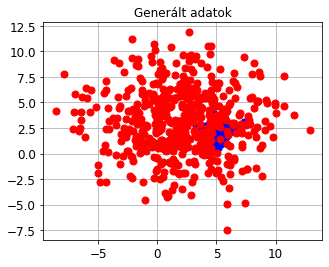

In [114]:
# Generált adatok előállítása a kísérlethez
# random_state a második argumentum

random_state = int(sys.argv[2])

dataset = random_dataset(ndataset = 603, nd = 3000)

lb, ub = dataset.X.min(), dataset.X.max()


fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.title("Generált adatok")
fig.sp.plot_ds(dataset)
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'gen_dist.png')



Tréning, validációs és teszt adatok halmazának létrehozása

In [116]:
n_tr = int(dataset.num_samples/3)  # Number of training set samples
n_val = int(dataset.num_samples/3)  # Number of validation set samples
n_ts = int(dataset.num_samples/3)  # Number of test set samples


# Split in training, validation and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr + n_val, test_size=n_ts, random_state=random_state)
tr_val, ts = splitter.split(dataset)
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_val, random_state=random_state)
tr, val = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
val.X = nmz.transform(val.X)
ts.X = nmz.transform(ts.X)

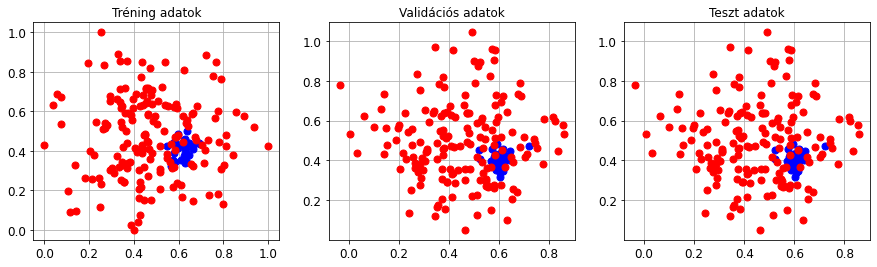

In [118]:
fig = CFigure(4,15)
fig.subplot(1, 3, 1)
fig.sp.title("Tréning adatok")
fig.sp.plot_ds(tr)
fig.subplot(1, 3, 2)
fig.sp.title("Validációs adatok")
fig.sp.plot_ds(val)
fig.subplot(1, 3, 3)
fig.sp.title("Teszt adatok")
fig.sp.plot_ds(ts)
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'tr_ts_dist.png')

Modell-illesztés


Estimating the best training parameters of Logistic ...
The best parameters for 'Logistic' are:  [('C', 0.1)]
Training of Logistic ...
Classifier: Logistic	Accuracy: 83.50%
2021-11-01 18:02:49,583 - py.warnings - WARNING - C:\Users\Administrator\anaconda3\lib\site-packages\secml\figure\_plots\c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return self._sp.contour(x, y, z, *args, **kwargs)


Estimating the best training parameters of Ridge ...
The best parameters for 'Ridge' are:  [('alpha', 0.005)]
Training of Ridge ...
Classifier: Ridge	Accuracy: 83.50%

Estimating the best training parameters of SVM Linear ...
The best parameters for 'SVM Linear' are:  [('C', 0.1)]
Training of SVM Linear ...
Classifier: SVM Linear	Accuracy: 83.50%
2021-11-01 18:02:50,293 - py.warnings - WARNING - C:\Users\Administrator\anaconda3\lib\site-packages\secml\figure\_plots\c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return self._sp.con

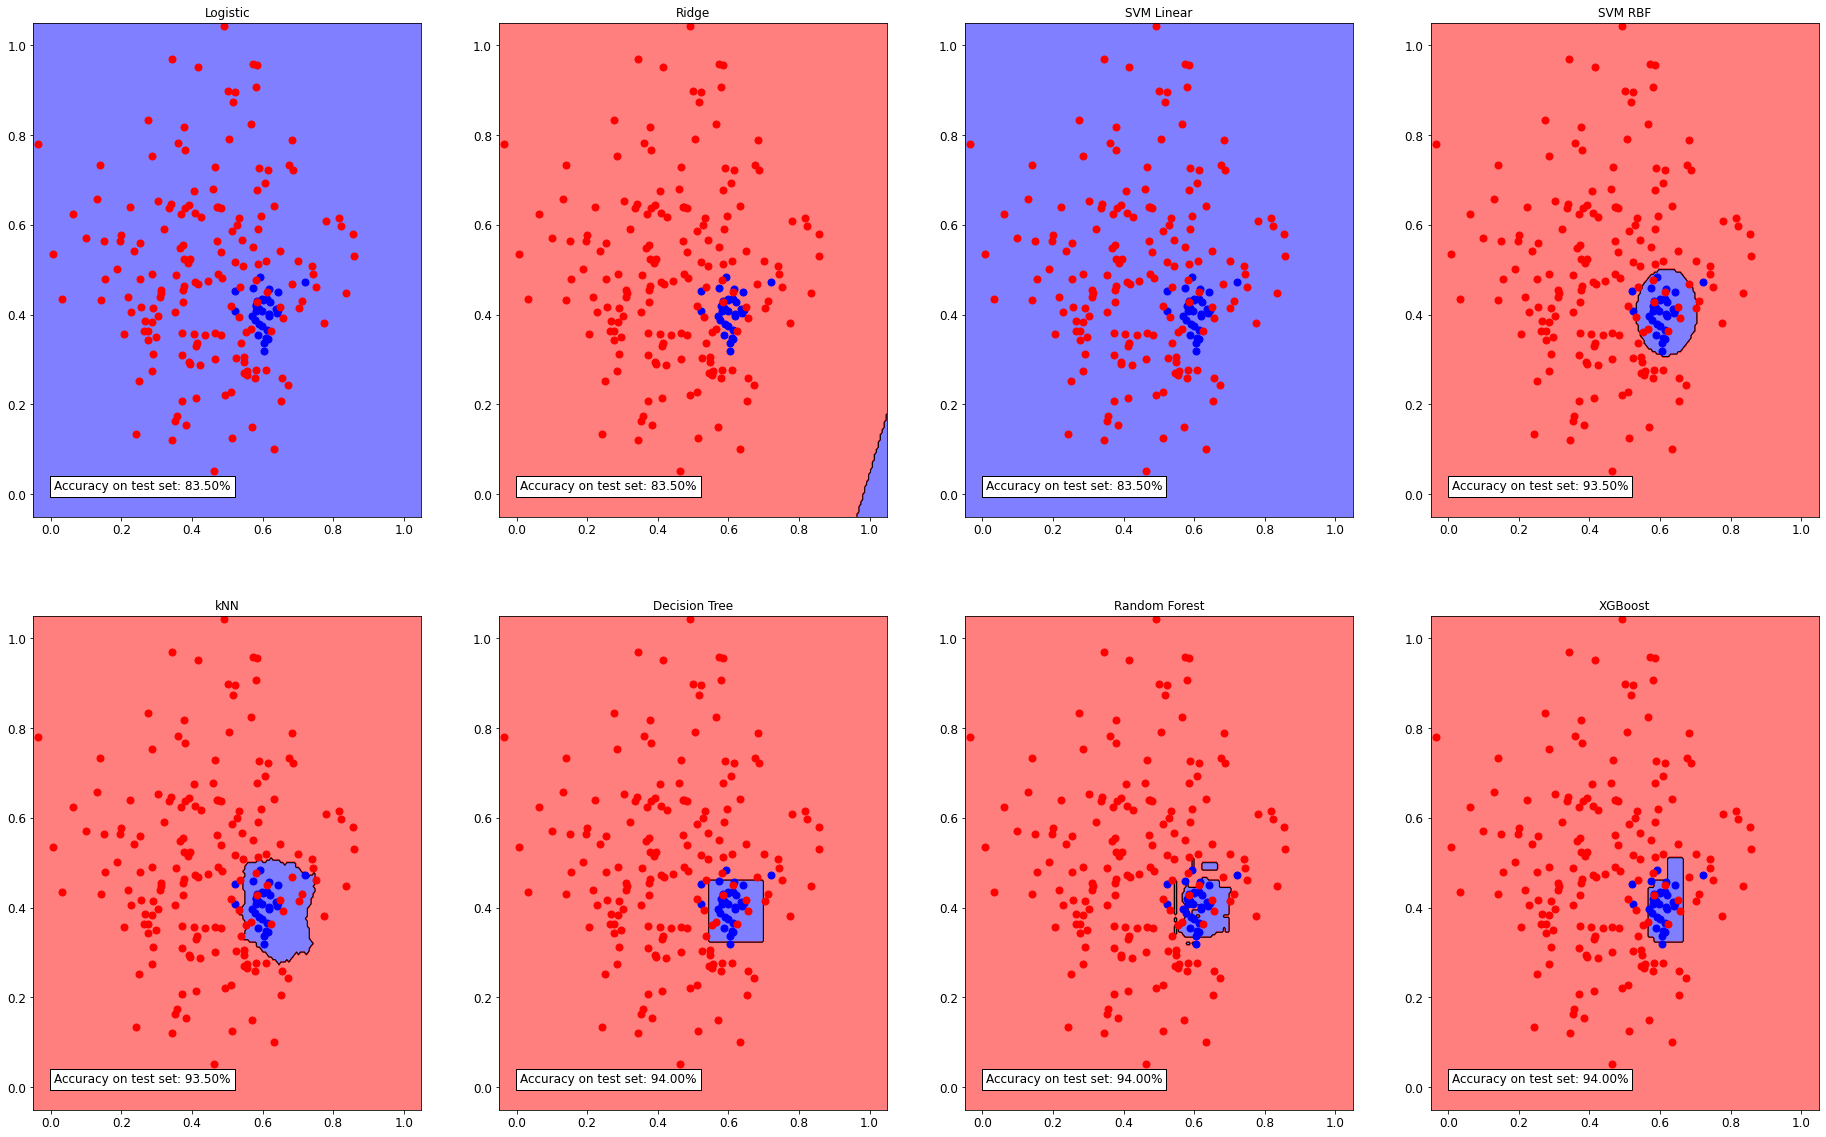

In [119]:
# Metric to use for training and performance evaluation
# AUC miatt
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Modellek
from secml.ml.classifiers import CClassifierSVM, CClassifierKNN, CClassifierDecisionTree, CClassifierRandomForest, CClassifierRidge, CClassifierLogistic

# Kernel
from secml.ml.kernels import CKernelRBF

from collections import namedtuple
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')

from secml.data.splitter import CDataSplitterKFold


clf_list = [
    CLF(clf_name='Logistic',
        clf=CClassifierLogistic(random_state=random_state),
        xval_parameters={'C': [0.1, 1, 10]}),
    CLF(clf_name='Ridge',
        clf=CClassifierRidge(alpha=1.0, max_iter=100000.0, class_weight=None, tol=0.0001, fit_intercept=True),
        xval_parameters={'alpha': [0.005,0.1,0.5,1,2, 5, 10]}),
    CLF(clf_name='SVM Linear',
        clf=CClassifierSVM(),
        xval_parameters={'C': [0.1, 1, 10]}),
    CLF(clf_name='SVM RBF',
        clf=CClassifierSVM(kernel='rbf'),
        xval_parameters={'C': [0.1, 1, 10],  'kernel.gamma': [1, 10, 100]}),   
    CLF(clf_name='kNN',
        clf=CClassifierKNN(),
        xval_parameters={'n_neighbors': [5, 10, 20]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierDecisionTree(random_state=random_state),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='Random Forest',
        clf=CClassifierRandomForest(random_state=random_state),
        xval_parameters={'n_estimators': [10, 20, 30]}),
    CLF(clf_name='XGBoost',
        clf=CClassifierXGBoost(random_state=1, learning_rate=0.01, eval_metric='logloss'),
        xval_parameters={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]})
]

#fig = CFigure(width=5 * len(clf_list) / 2, height=5 * 5)
fig = CFigure(width=4 * len(clf_list), height=5 * len(clf_list)/2)
#fig = CFigure(4,15)

# A kimentett legjobb modellek
clfarray = []

for i, test_case in enumerate(clf_list):

    clf = test_case.clf
    xval_params = test_case.xval_parameters

    print("\nEstimating the best training parameters of {:} ..."
          "".format(test_case.clf_name))
    
    
    best_params = clf.estimate_parameters(
        dataset=tr, parameters=xval_params, splitter=CDataSplitterKFold(num_folds=8, random_state=random_state),
        metric='accuracy', perf_evaluator='xval')
    

    print("The best parameters for '{:}' are: ".format(test_case.clf_name),
        [(k, best_params[k]) for k in sorted(best_params)])

    print("Training of {:} ...".format(test_case.clf_name))
    clf.fit(tr.X, tr.Y)

    # Predictions on test set and performance evaluation
    y_pred = clf.predict(ts.X)
    acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

    print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))

    clfarray.append(clf)

    # Plot the decision function
    from math import ceil
    # Use `CFigure.subplot` to divide the figure in multiple subplots
    fig.subplot(2, int(ceil(len(clf_list) / 2)), i + 1)
    
    
    fig.sp.plot_decision_regions(clf, n_grid_points=200)

    fig.sp.plot_ds(ts)
    fig.sp.grid(grid_on=False)

    fig.sp.title(test_case.clf_name)
    fig.sp.text(0.01, 0.01, "Accuracy on test set: {:.2%}".format(acc),
                bbox=dict(facecolor='white'))

fig.show()
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'trained_models.png')

Támadáshoz szükséges pontok előállítása

Initial poisoning sample features: CArray([0.339482 0.713635])
Initial poisoning sample label: 1


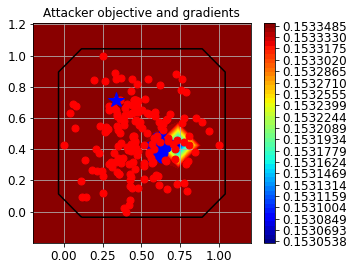

In [120]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded

# SVM
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 1000,
    'eps': 1e-6
}
from secml.adv.attacks import CAttackPoisoningSVM
pois_attack_svm = CAttackPoisoningSVM(classifier=clfarray[3],
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack_svm.x0 = xc
pois_attack_svm.xc = xc
pois_attack_svm.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack_svm.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)

fig.tight_layout()
fig.show()
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'svm_gradient.png')

Initial poisoning sample features: CArray([0.339482 0.713635])
Initial poisoning sample label: 1


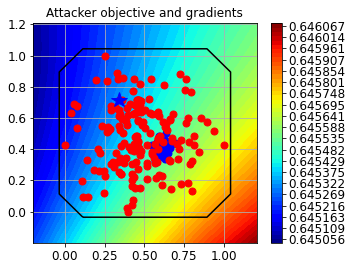

In [121]:
# Logisztikus

from secml.adv.attacks import CAttackPoisoningLogisticRegression
pois_attack_log = CAttackPoisoningLogisticRegression(classifier=clfarray[0],
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack_log.x0 = xc
pois_attack_log.xc = xc
pois_attack_log.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack_log.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)

fig.tight_layout()
fig.show()
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'log_gradient.png')

Initial poisoning sample features: CArray([0.339482 0.713635])
Initial poisoning sample label: 1


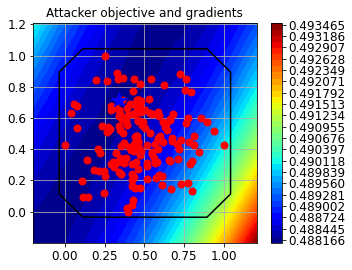

In [122]:
# Ridge
from secml.adv.attacks import CAttackPoisoningRidge
pois_attack_ridge = CAttackPoisoningRidge(classifier=clfarray[1], training_data=tr, val=val, distance='l2', dmax=0, lb=0, ub=1, y_target=None, solver_type='pgd-ls', solver_params=solver_params, init_type=None, random_seed=True)


# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack_ridge.x0 = xc
pois_attack_ridge.xc = xc
pois_attack_ridge.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack_ridge.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)

fig.tight_layout()
fig.show()
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'ridge_gradient.png')

In [123]:
# SVM poisioning
 

n_poisoning_points = 200  # Number of poisoning points to generate
pois_attack_svm.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack_svm.run(ts.X, ts.Y)
print("Attack complete!")

poision_points_svm = pois_ds

y_pred = clfarray[1].predict(ts.X)

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Attack started...
Attack complete!
Original accuracy on test set: 83.50%
Accuracy after attack on test set: 32.00%


In [124]:
# Ridge poisioning

n_poisoning_points = 200  # Number of poisoning points to generate
pois_attack_ridge.n_points = n_poisoning_points
pois_attack_ridge.init_type = 'random' #Ridgenél fontos!

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack_ridge.run(ts.X, ts.Y)
print("Attack complete!")

poision_points_ridge = pois_ds

y_pred = clfarray[3].predict(ts.X)

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Attack started...
Attack complete!
Original accuracy on test set: 93.50%
Accuracy after attack on test set: 42.50%


In [125]:
# Logistic posisioning

n_poisoning_points = 200  # Number of poisoning points to generate
pois_attack_log.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack_log.run(ts.X, ts.Y)
print("Attack complete!")

poision_points_logistic = pois_ds

y_pred = clfarray[2].predict(ts.X)

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Attack started...
Attack complete!
Original accuracy on test set: 83.50%
Accuracy after attack on test set: 34.00%


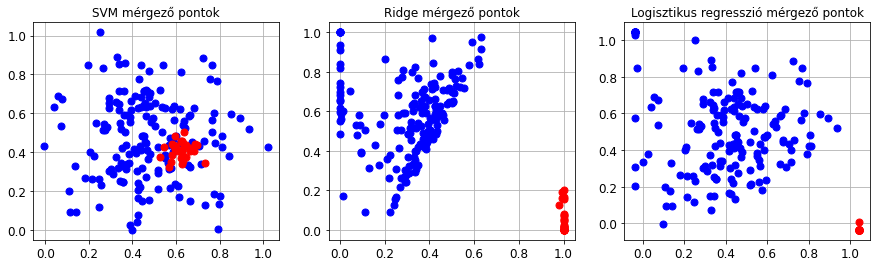

In [126]:
fig = CFigure(4,15)
fig.subplot(1, 3, 1)
fig.sp.title("SVM mérgező pontok")
fig.sp.plot_ds(poision_points_svm)
fig.subplot(1, 3, 2)
fig.sp.title("Ridge mérgező pontok")
fig.sp.plot_ds(poision_points_ridge)
fig.subplot(1, 3, 3)
fig.sp.title("Logisztikus regresszió mérgező pontok")
fig.sp.plot_ds(poision_points_logistic)
fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'poision_points.png')

Mintavétel a mérgező pontokból

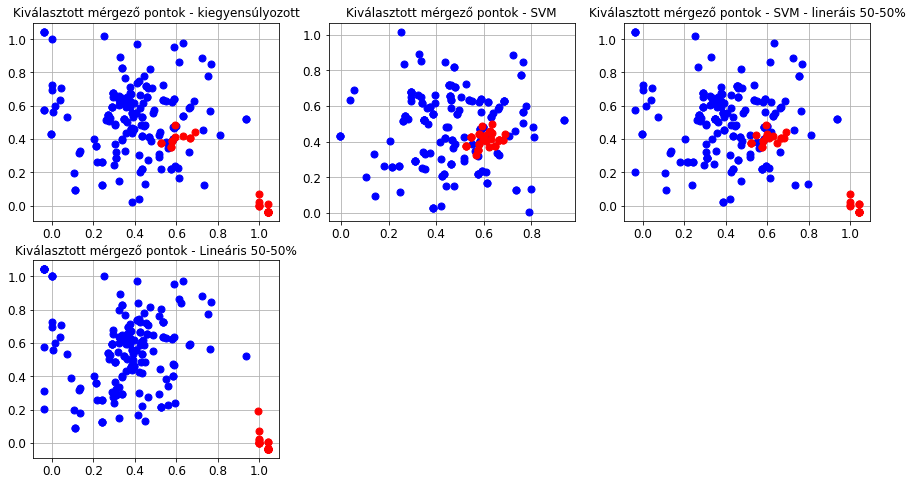

In [128]:
from secml.array import CArray
from random import *

rnd_num = n_poisoning_points # hány véletlen számot szeretnék
rndarray = []
rndselector = []

pSLR = [
    [0.3333, 0.3333, 0.3333],
    [1, 0, 0],
    [0.5, 0.25, 0.25],
    [0, 0.5, 0.5]
]

ppC = [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]


    
# Generate random array for elements and one for selector
for x in range(rnd_num):
    rndarray.append(randint(0, rnd_num-1))
    rndselector.append(random())
#print(rndarray)
#print(rndselector)

dfa=[]

for q in range(0,len(pSLR)):
    if rndselector[0] < pSLR[q][0]:
        df = poision_points_svm[[rndarray[0]],[0,1]]
    elif rndselector[0] < (pSLR[q][0] + pSLR[q][1]):
        df = poision_points_logistic[[rndarray[0]],[0,1]]
    else:
        df = poision_points_ridge[[rndarray[0]],[0,1]]

    for x in range(0,rnd_num-1):
        if rndselector[x] < pSLR[q][0]:
            df = df.append(poision_points_svm[[rndarray[x]],[0,1]])
        elif rndselector[x] < (pSLR[q][0] + pSLR[q][1]):
            df = df.append(poision_points_logistic[[rndarray[x]],[0,1]])
        else:
            df = df.append(poision_points_ridge[[rndarray[x]],[0,1]])

    
    dfa.append(df)

fig = CFigure(8,15)
fig.subplot(2, 3, 1)
fig.sp.title("Kiválasztott mérgező pontok - kiegyensúlyozott")
fig.sp.plot_ds(dfa[0])
fig.subplot(2, 3, 2)
fig.sp.title("Kiválasztott mérgező pontok - SVM")
fig.sp.plot_ds(dfa[1])
fig.subplot(2, 3, 3)
fig.sp.title("Kiválasztott mérgező pontok - SVM - lineráis 50-50%")
fig.sp.plot_ds(dfa[2])
fig.subplot(2, 3, 4)
fig.sp.title("Kiválasztott mérgező pontok - Lineáris 50-50%")
fig.sp.plot_ds(dfa[3])

fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) + str(sys.argv[2]) +'poision_sample.png')

Most ugrik a majom a vízbe...


Poisioning point weights: SVM: 0.3333 Logistic: 0.3333 Ridge: 0.3333

Amount of poision points: 1.0%
CDataset{'X': CArray(1, 2)(dense: [[0.363413 0.650936]]), 'Y': CArray(1,)(dense: [0]), 'header': None}

Estimating the best training parameters of Logistic ...
The best parameters for 'Logistic' are:  [('C', 0.1)]
Training of Logistic ...
Classifier: Logistic	Accuracy: 83.50%
Classifier: Logistic	Poisioned accuracy: 83.50%

EXPAUC	01	123	Mon Nov  1 18:27:13 2021	S:0.3333	L:0.3333	R:0.3333	Logistic	PP:	1.0	oAUC:	0.835	pAUC: 	0.835
2021-11-01 18:27:13,465 - py.warnings - WARNING - C:\Users\Administrator\anaconda3\lib\site-packages\secml\figure\_plots\c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return self._sp.contour(x, y, z, *args, **kwargs)

2021-11-01 18:27:13,545 - py.warnings - WARNING - C:\Users\Administrator\anaconda3\lib\site-packages\secml\figure\_plots\c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return 

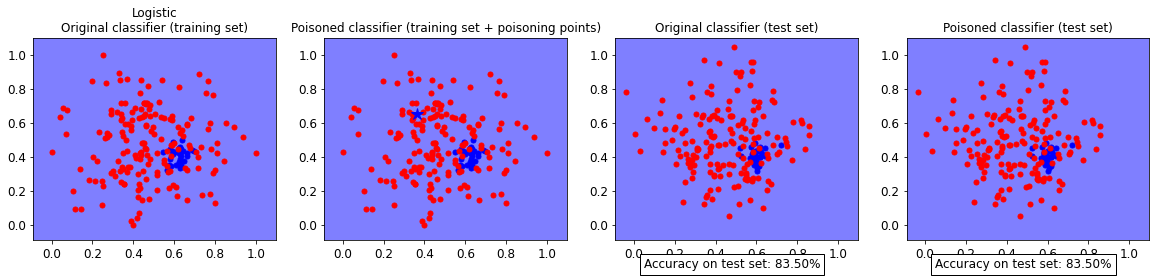

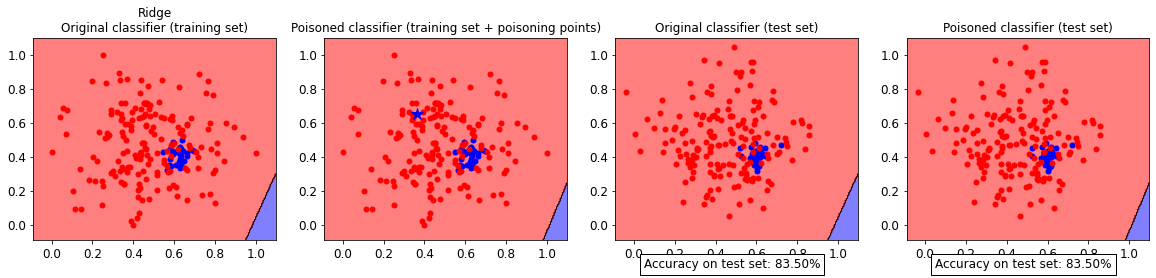

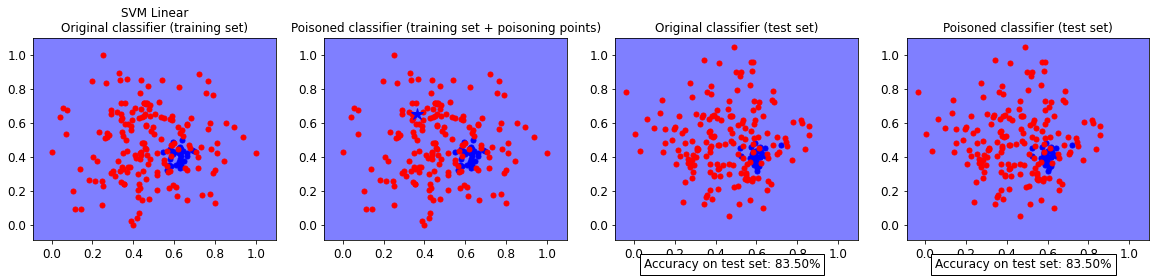

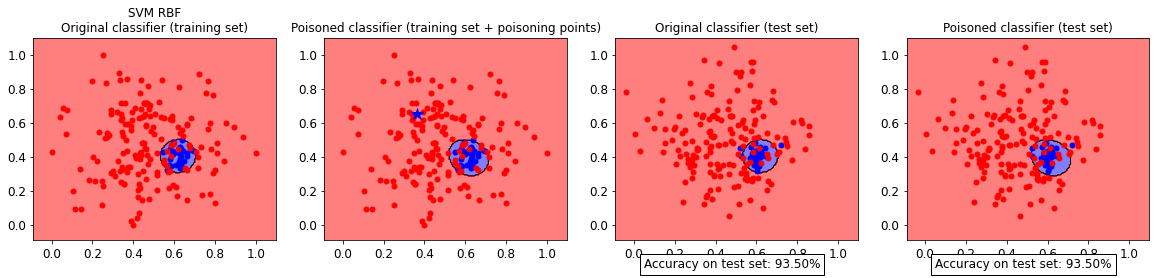

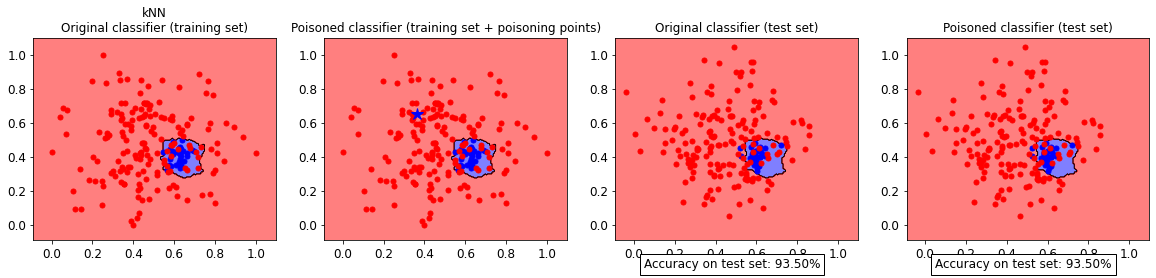

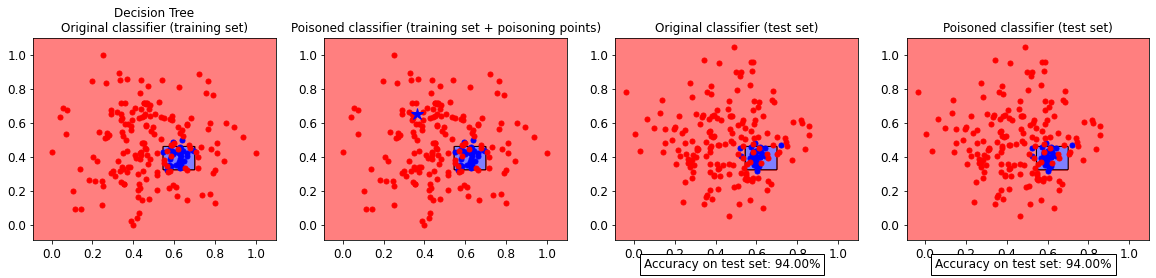

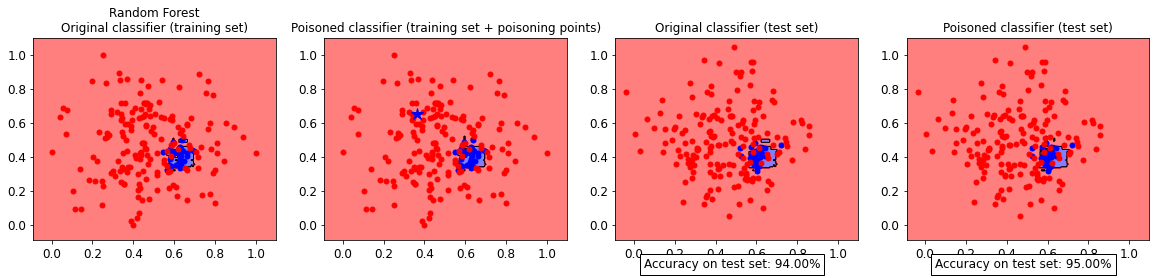

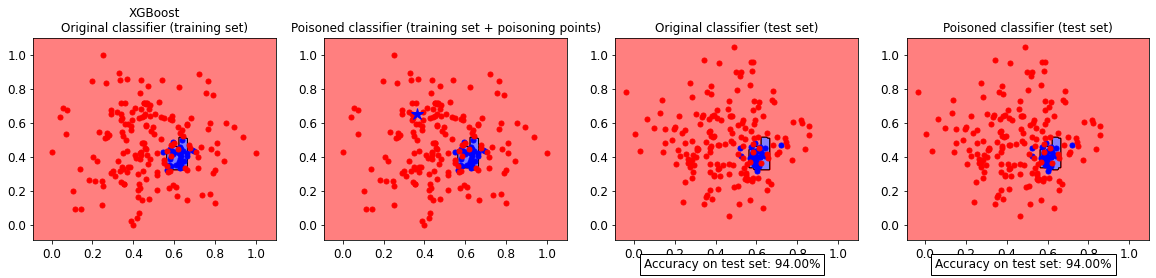


Amount of poision points: 2.0%
CDataset{'X': CArray(3, 2)(dense: [[0.363413 0.650936] [0.57662  0.35134 ] [0.66478  0.407839]]), 'Y': CArray(3,)(dense: [0 1 1]), 'header': None}

Estimating the best training parameters of Logistic ...
The best parameters for 'Logistic' are:  [('C', 0.1)]
Training of Logistic ...
Classifier: Logistic	Accuracy: 83.50%
Classifier: Logistic	Poisioned accuracy: 83.50%

EXPAUC	01	123	Mon Nov  1 18:27:30 2021	S:0.3333	L:0.3333	R:0.3333	Logistic	PP:	2.0	oAUC:	0.835	pAUC: 	0.835
2021-11-01 18:27:30,900 - py.warnings - WARNING - C:\Users\Administrator\anaconda3\lib\site-packages\secml\figure\_plots\c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return self._sp.contour(x, y, z, *args, **kwargs)

2021-11-01 18:27:30,980 - py.warnings - WARNING - C:\Users\Administrator\anaconda3\lib\site-packages\secml\figure\_plots\c_plot.py:550: UserWarning: No contour levels were found within the data range.
  return self._sp.contour(x, y, z, 

KeyboardInterrupt: 

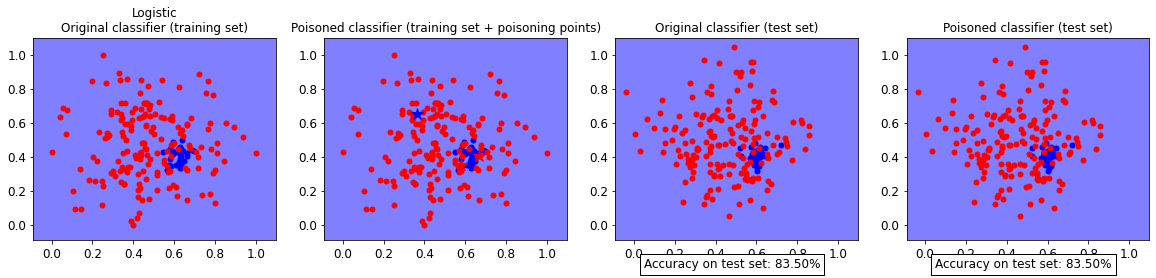

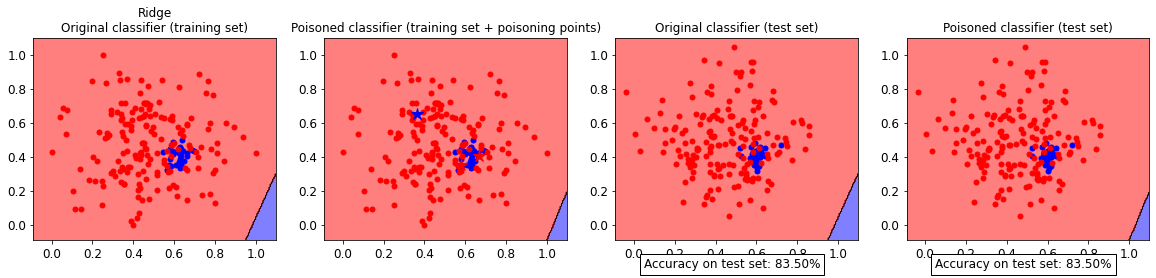

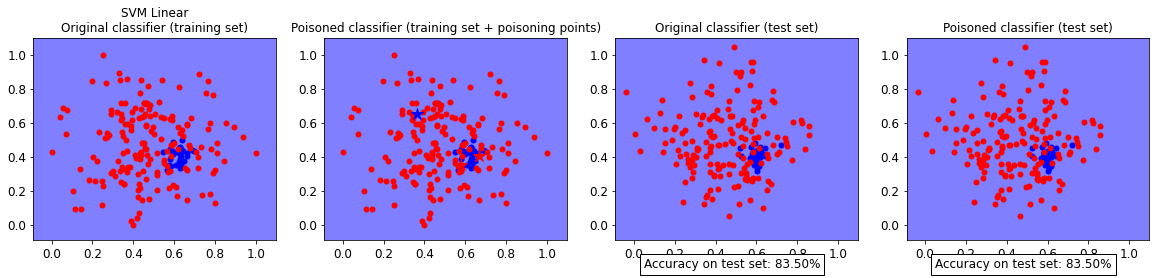

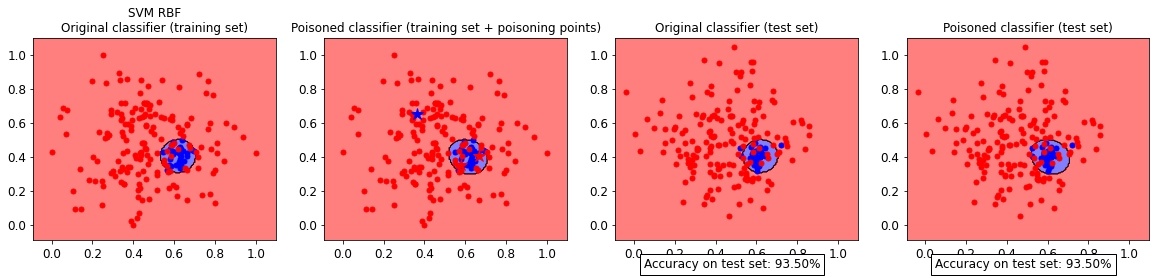

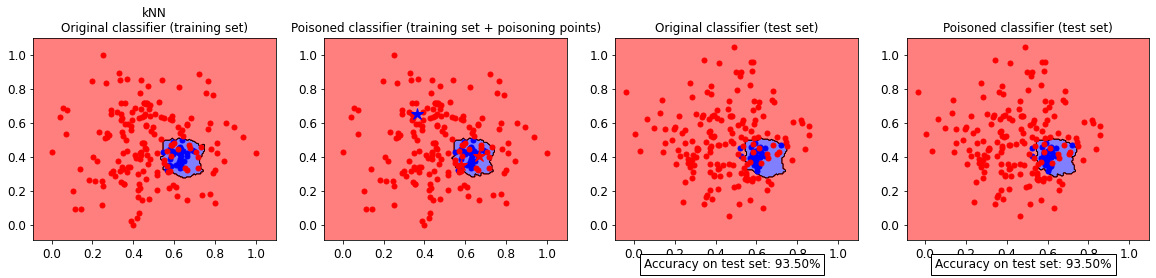

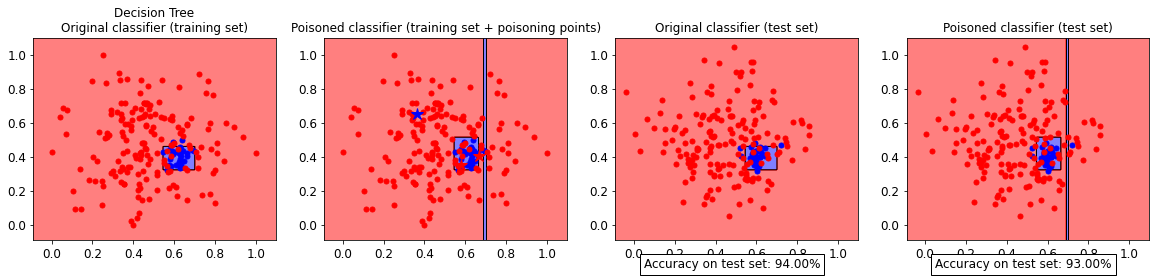

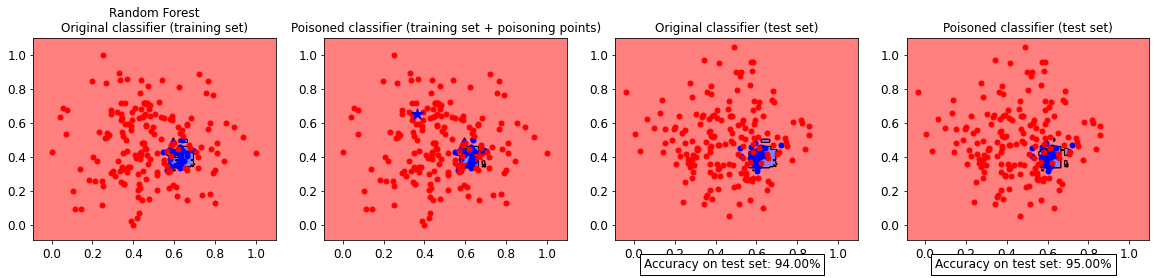

In [133]:
for j in range(0,len(pSLR)):
    print("\nPoisioning point weights: SVM: " + str(pSLR[j][0]) + " Logistic: " + str(pSLR[j][1]) + " Ridge: " + str(pSLR[j][2]))
    tr_ps = dfa[j]
    for k in range(0, len(ppC)):
        print("\nAmount of poision points: " + str(ppC[k]*100) +"%")
        np = int(ppC[k]*ts.num_samples/(1-ppC[k]))
        
        # Make a poisioning sample
        # tr_px, ts_px = CTrainTestSplit(train_size=np, random_state=0, shuffle=False).compute_indices(dfa[j])
        # print(tr_px.Y)
        
        
        for q in range(0,np-1):
            if (q == 0):
                tr_px = tr_ps[[rndarray[0]],[0,1]]
            elif (q < tr_ps.num_samples):
                tr_px = tr_px.append(tr_ps[[q],[0,1]])
            else:
                tr_px = tr_px.append(tr_ps[[q % tr_ps.num_samples],[0,1]])
                
        print (tr_px)
        
        for i, test_case in enumerate(clf_list):

            clf = test_case.clf
            xval_params = test_case.xval_parameters

            print("\nEstimating the best training parameters of {:} ..."
                  "".format(test_case.clf_name))

            best_params = clf.estimate_parameters(
                dataset=tr, parameters=xval_params, splitter=CDataSplitterKFold(num_folds=8, random_state=random_state),
                metric='accuracy', perf_evaluator='xval')

            print("The best parameters for '{:}' are: ".format(test_case.clf_name),
                  [(k, best_params[k]) for k in sorted(best_params)])

            print("Training of {:} ...".format(test_case.clf_name))
            clf.fit(tr.X, tr.Y)

            # Predictions on test set and performance evaluation
            y_pred = clf.predict(ts.X)
            acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

            print("Classifier: {:}\tAccuracy: {:.2%}".format(test_case.clf_name, acc))
            
    
            # Evaluate the accuracy of the original classifier
            acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
    
            # Compute predictions on a test set
            y_pred = clf.predict(ts.X)
    
            # Training of the poisoned classifier
            pois_clf = clf.deepcopy()
            pois_tr = tr.append(tr_px)  # Join the training set with the poisoning points
            pois_clf.fit(pois_tr.X, pois_tr.Y)
    
    
            # Compute predictions on a test set
            pois_y_pred = pois_clf.predict(ts.X)
    
            # Evaluate the accuracy after the poisoning attack
            pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)
            
            print("Classifier: {:}\tPoisioned accuracy: {:.2%}".format(test_case.clf_name, pois_acc))
    
            # Basic statistics
            print('\nEXPAUC\t'+ sys.argv[1] +'\t' + sys.argv[2] + '\t' + time.asctime( time.localtime(time.time()) ) + '\t' +
                  "S:" + str(pSLR[j][0]) + '\t' + "L:" + str(pSLR[j][1]) + '\t' + 
                  "R:" + str(pSLR[j][2]) + '\t' + test_case.clf_name + '\t' + 
                  "PP:" + '\t' + str(ppC[k]*100) + '\t' + "oAUC:" + '\t' + str(acc) + '\t' + "pAUC: " + '\t' + str(pois_acc)
                 ) 

            # Define common bounds for the subplots
            min_limit = min(pois_tr.X.min(), ts.X.min())
            max_limit = max(pois_tr.X.max(), ts.X.max())
            grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

            fig = CFigure(5 *7 , 20)

            fig.subplot(len(clfarray), 4, 1)
            fig.sp.title(test_case.clf_name + "\n" + "Original classifier (training set)")
            fig.sp.plot_decision_regions(
                clf, n_grid_points=200, grid_limits=grid_limits)
            fig.sp.plot_ds(tr, markersize=5)
            fig.sp.grid(grid_on=False)

            fig.subplot(len(clfarray), 4, 2)
            fig.sp.title("Poisoned classifier (training set + poisoning points)")
            fig.sp.plot_decision_regions(
                pois_clf, n_grid_points=200, grid_limits=grid_limits)
            fig.sp.plot_ds(tr, markersize=5)
            fig.sp.plot_ds(tr_px, markers='*', markersize=12) #pois_ds , '*' ??? tömbben
            fig.sp.grid(grid_on=False)

            fig.subplot(len(clfarray), 4, 3)
            fig.sp.title("Original classifier (test set)")
            fig.sp.plot_decision_regions(
                clf, n_grid_points=200, grid_limits=grid_limits)
            fig.sp.plot_ds(ts, markersize=5)
            fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc), 
                        bbox=dict(facecolor='white'))
            fig.sp.grid(grid_on=False)

            fig.subplot(len(clfarray), 4, 4)
            fig.sp.title("Poisoned classifier (test set)")
            fig.sp.plot_decision_regions(
                pois_clf, n_grid_points=200, grid_limits=grid_limits)
            fig.sp.plot_ds(ts, markersize=5)
            fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc), 
                        bbox=dict(facecolor='white'))
            fig.sp.grid(grid_on=False)
            
            fig.savefig('C:\\Users\\Administrator\\Documents\\Runs\\' + str(sys.argv[1]) +'_'+ str(sys.argv[2]) +'_'+ str(pSLR[j])+'_'+ str(ppC[k]) +'_'+ test_case.clf_name + '_attack_plot.png',bbox_inches='tight')

        fig.show()
        